In [216]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def get_N(l, alpha, b, rho):
    return alpha + b * (rho * l + np.sqrt(l**2 + 1))

def get_Np(l, b, rho):
    return b * (rho + l / np.sqrt(l**2 + 1))

def get_Npp(l, b):
    return b / (np.sqrt(l**2 + 1) ** 3)

def get_G1(l, alpha, b, rho, mu):
    N = get_N(l, alpha, b, rho)
    Np = get_Np(l, b, rho)
    A1 = 1 - Np * ((l + mu)/(2*N) + 1/4)
    A2 = 1 - Np * ((l + mu)/(2*N) - 1/4)
    return A1 * A2

def get_G2(l, alpha, b, rho):
    N = get_N(l, alpha, b, rho)
    Np = get_Np(l, b, rho)
    Npp = get_Npp(l, b)
    return Npp - Np**2/(2*N)

def get_G(l, alpha, b, rho, mu, sigma):
    G1 = get_G1(l, alpha, b, rho, mu)
    G2 = get_G2(l, alpha, b, rho)
    return G1 + G2/(2 * sigma)

def get_l_star(rho): # critical point at minimum of N (N''>0 -> N is convex)
    return - rho / np.sqrt(1 - rho**2)

def get_g(k, a, b, rho, m, sigma):
    # Durrelman condition
    alpha = a/sigma
    mu = m/sigma
    l = (k - m)/sigma # k = sigma * (l + mu)
    return get_G(l, alpha, b, rho, mu, sigma)

def get_k(K, S0, T, r, q):
    #log forward moneyness
    F = S0 * np.exp((r - q) * T)
    return np.log(K / F)

def get_rnd(k, svi_params):
    a, b, rho, m, sigma = svi_params
    w_svi_k = a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))
    sqrt_w = np.sqrt(w_svi_k)
    gk = get_g(k, a, b, rho, m, sigma)
    d2 = - (k/sqrt_w + sqrt_w/2)
    return gk * np.exp(-d2**2/2) / np.sqrt(2 * np.pi * w_svi_k)

def get_w_svi(k, a, b, rho, m, sigma):
    alpha = a/sigma
    mu = m/sigma
    l = (k - m)/sigma # k = sigma * (l + mu)
    return get_N(l, alpha, b, rho)

def bs_call(S0, K, T, r, q, sigma):
    d1 = (np.log(S0/K) + (r - q + 0.5*sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * np.exp(-q*T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

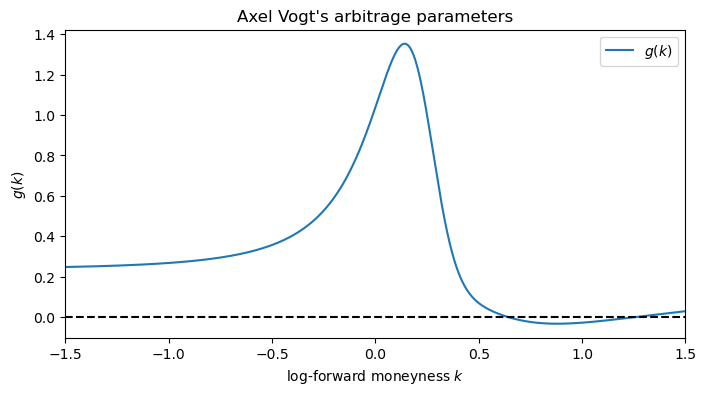

In [217]:
# Axel Vogt
a = -0.041
b = 0.1331
rho = 0.306
m = 0.3586
sigma = 0.4153
k_lst = np.linspace(-1.5, 1.5, 1000)
l_lst = [(k-m)/sigma for k in k_lst]
g_lst = [get_g(k, a, b, rho, m, sigma) for k in k_lst]

plt.figure(figsize=(8, 4))
plt.plot(k_lst, g_lst, label=r"$g(k)$")
plt.axhline(0, linestyle="--", color='black')
plt.xlabel(r"log-forward moneyness $k$")
plt.xlim(-1.5, 1.5)
plt.ylabel(r"$g(k)$")
plt.title("Axel Vogt's arbitrage parameters")
plt.legend()
plt.show()

In [218]:
a = -0.041
b = 0.1331
rho = 0.306
m = 0.3586
sigma = 0.4153
svi_params = (a, b, rho, m, sigma)

S0 = 100
T = 1
r = 0.05
q = 0.01
dK = 0.1
K_lst = np.arange(dK, 500, dK) # strike
intrinsic_lst = [max(S0 - K, 0) for K in K_lst]
dkdK_lst = np.array([1/K for K in K_lst])
k_lst = [get_k(K, S0, T, r, q) for K in K_lst] # log-forward M
g_lst = [get_g(k, a, b, rho, m, sigma) for k in k_lst]
rnd_lst = np.array([get_rnd(k, svi_params) for k in k_lst])
w_svi_lst = [get_w_svi(k, a, b, rho, m, sigma) for k in k_lst]
iv_lst = [np.sqrt(w/T) for w in w_svi_lst]
call_lst = [bs_call(S0, K, T, r, q, iv) for K, iv in zip(K_lst, iv_lst)]

# E[p] = rnd * dk = rnd * dk/dK * dK
print(f"Integral of density: {np.sum(rnd_lst * dkdK_lst * dK):.6f}")# Expectation

# Or
# dk = 0.001
# k_lst = np.arange(-10, 10, dk)
# rnd_lst = np.array([get_rnd(k, T, svi_params) for k in k_lst])
# np.sum(rnd_lst * dk) # Expectation

Integral of density: 0.999992


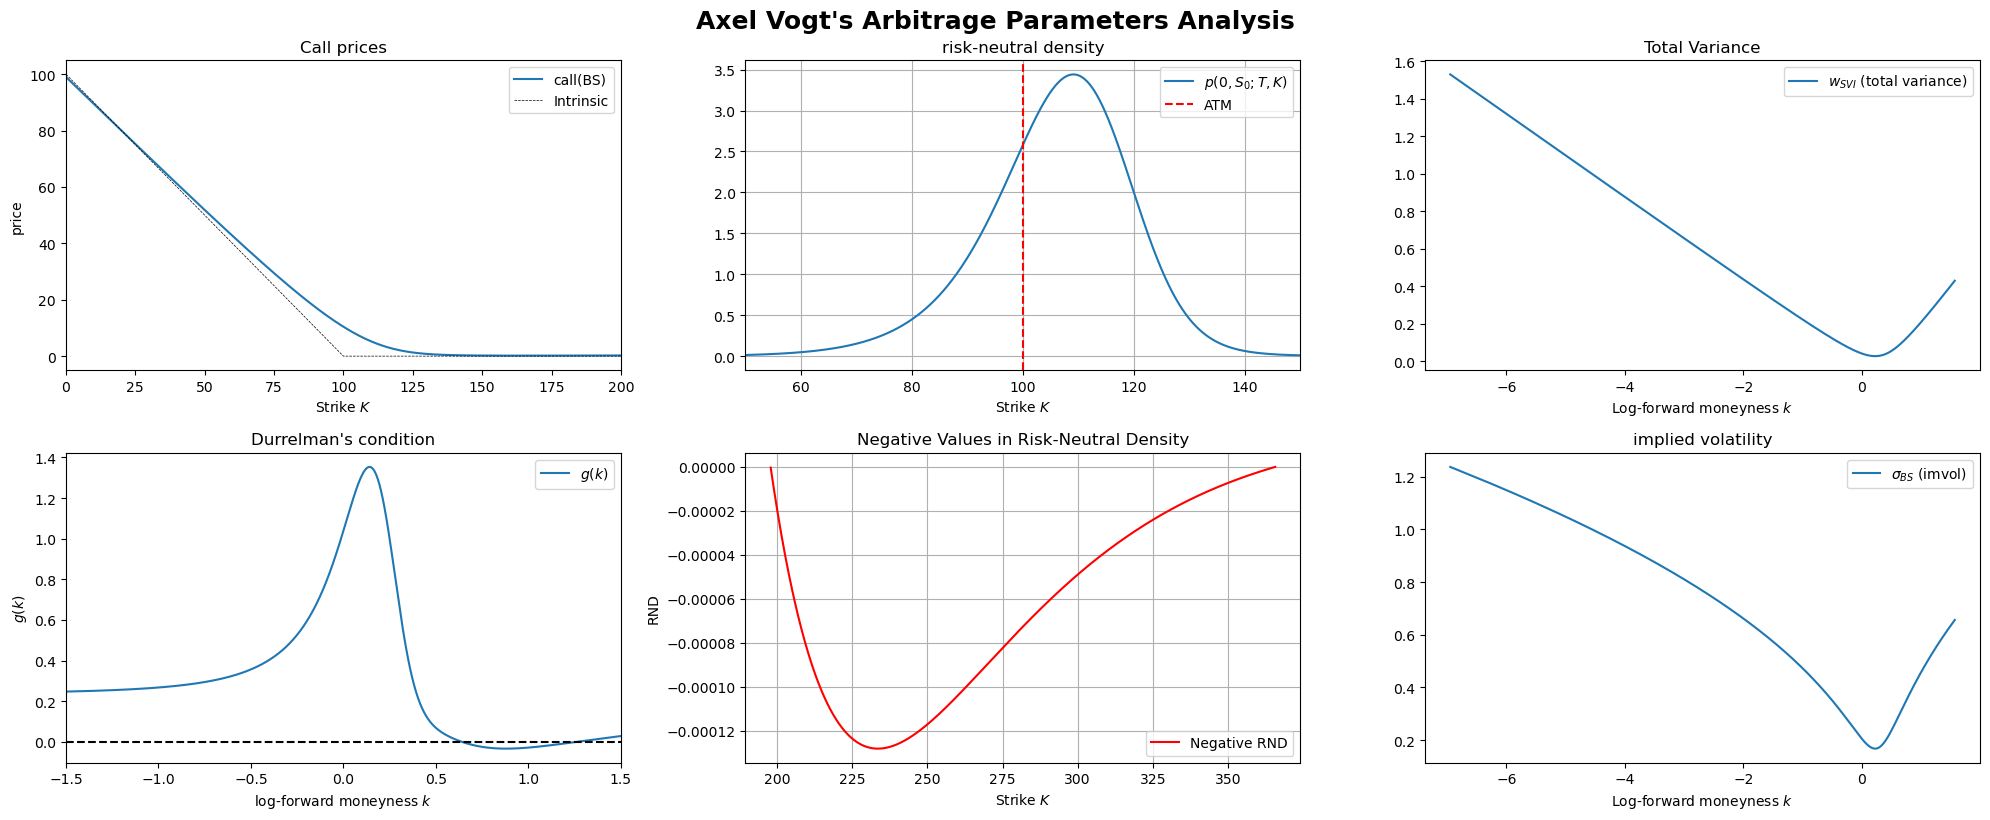

In [219]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
axes[0][0].plot(K_lst, call_lst, label='call(BS)')
axes[0][0].plot(K_lst, intrinsic_lst, linestyle="--", color='black', label='Intrinsic', linewidth=0.5)
axes[0][0].set_title("Call prices")
axes[0][0].set_xlabel(r"Strike $K$")
axes[0][0].set_ylabel("price")
axes[0][0].set_xlim(0, 200)
axes[0][0].legend(loc='upper right')

axes[0][1].plot(K_lst, rnd_lst, label=r'$p(0,S_0;T,K)$')
axes[0][1].set_title('risk-neutral density')
axes[0][1].axvline(S0, linestyle='--', color='red', label='ATM')
axes[0][1].set_xlim(S0*0.5, S0*1.5)
axes[0][1].set_xlabel(r"Strike $K$")
axes[0][1].legend(loc='upper right')
axes[0][1].grid(True)

axes[0][2].plot(k_lst, w_svi_lst, label=r'$w_{SVI}$ (total variance)')
axes[0][2].set_title("Total Variance")
axes[0][2].set_xlabel(r"Log-forward moneyness $k$")
axes[0][2].legend(loc='upper right')

axes[1][0].plot(k_lst, g_lst, label=r"$g(k)$")
axes[1][0].axhline(0, linestyle="--", color='black')
axes[1][0].set_xlabel(r"log-forward moneyness $k$")
axes[1][0].set_ylabel(r"$g(k)$")
axes[1][0].set_title("Durrelman's condition")
axes[1][0].set_xlim(-1.5, 1.5)
axes[1][0].legend(loc='upper right')

neg_mask = rnd_lst < 0
K_neg = K_lst[neg_mask]
rnd_neg = rnd_lst[neg_mask]
axes[1][1].plot(K_neg, rnd_neg, label="Negative RND", color='red')
axes[1][1].set_xlabel(r"Strike $K$")
axes[1][1].set_ylabel("RND")
axes[1][1].set_title("Negative Values in Risk-Neutral Density")
axes[1][1].grid(True)
axes[1][1].legend()

axes[1][2].plot(k_lst, iv_lst, label=r'$\sigma_{BS}$ (imvol)')
axes[1][2].set_title("implied volatility")
axes[1][2].set_xlabel(r"Log-forward moneyness $k$")
axes[1][2].legend(loc='upper right')

plt.tight_layout()
plt.suptitle("Axel Vogt's Arbitrage Parameters Analysis", fontsize=18, fontweight='bold', y=1.02)
plt.show()

In [202]:
import pandas as pd
from scipy.optimize import minimize

def svi_raw(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

def svi_objective(params, k_data, w_data):
    a, b, rho, m, sigma = params
    w_model = svi_raw(k_data, a, b, rho, m, sigma)
    return np.sum((w_data - w_model)**2)

def fit_svi_unconstrained(k_data, w_data):
    # initial guess
    x0 = [0.1 * np.min(w_data), 0.1, 0.0, 0.0, 0.1]
    result = minimize(svi_objective, x0, args=(k_data, w_data), method='L-BFGS-B')
    if result.success: return result.x  # a, b, rho, m, sigma
    else: raise RuntimeError("SVI optimization failed:", result.message)
    
def print_svi_params(params):
    a, b, rho, m, sigma = params
    print(f"SVI Parameters (Unconstrained Fit):")
    print(f"  a     = {a:.6f}")
    print(f"  b     = {b:.6f}")
    print(f"  rho   = {rho:.6f}")
    print(f"  m     = {m:.6f}")
    print(f"  sigma = {sigma:.6f}")

SVI Parameters (Unconstrained Fit):
  a     = -0.039209
  b     = 0.111570
  rho   = 0.072830
  m     = 0.152852
  sigma = 0.390597


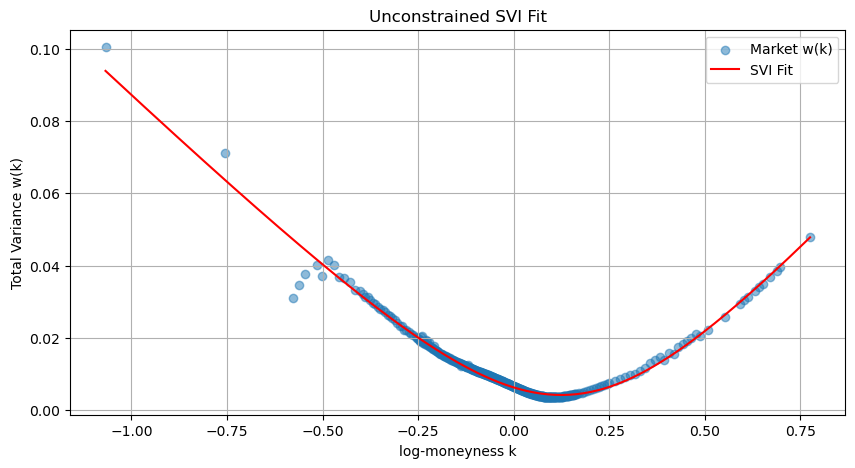

In [204]:
# Real market data: SPX 6/20/25 at Apr 28
S0 = 5504.21875
T = 0.144643106
r = 0.04551324
q = 0.01696706
F = S0 * np.exp((r-q)*T)
data = pd.read_csv("spx_0620.csv")
data['iv_mid'] = data['iv_mid'].replace(0, np.nan)
data['k'] = np.log(data['K']/F)
data['w'] = data['iv_mid'] ** 2 * T
data.dropna(inplace=True)

svi_params = fit_svi_unconstrained(data['k'], data['w'])

# Visualization
k_plot = np.linspace(min(data['k']), max(data['k']), 200)
w_fit = svi_raw(k_plot, *svi_params)

plt.figure(figsize=(10, 5))
plt.scatter(data['k'], data['w'], label='Market w(k)', alpha=0.5)
plt.plot(k_plot, w_fit, label='SVI Fit', color='red')
plt.xlabel('log-moneyness k')
plt.ylabel('Total Variance w(k)')
plt.title('Unconstrained SVI Fit')
plt.legend()
plt.grid(True)
plt.show()

In [214]:
S0 = 5504.21875
T = 0.144643106
r = 0.04551324
q = 0.01696706
F = S0 * np.exp((r-q)*T)
svi_params = fit_svi_unconstrained(data['k'], data['w'])
a, b, rho, m, sigma = svi_params

dk = 0.01
k_lst = np.arange(-10, 10, dk) # log-forward moneyness
g_lst = [get_g(k, a, b, rho, m, sigma) for k in k_lst]
rnd_lst = np.array([get_rnd(k, svi_params) for k in k_lst])
print_svi_params(svi_params)
print(f"Integral of density: {np.sum(rnd_lst * dk):.6f}")# Expectation
print("Do the parameters accompany negative density?:", np.any(rnd_lst < 0))

K_lst = np.array([F * np.exp(k) for k in k_lst])
intrinsic_lst = [max(S0 - K, 0) for K in K_lst]
call_lst = [bs_call(S0, K, T, r, q, iv) for K, iv in zip(K_lst, iv_lst)]
w_svi_lst = [get_w_svi(k, a, b, rho, m, sigma) for k in k_lst]
iv_lst = [np.sqrt(w/T) for w in w_svi_lst]

SVI Parameters (Unconstrained Fit):
  a     = -0.039209
  b     = 0.111570
  rho   = 0.072830
  m     = 0.152852
  sigma = 0.390597
Integral of density: 1.000000
Do the parameters accompany negative density?: True


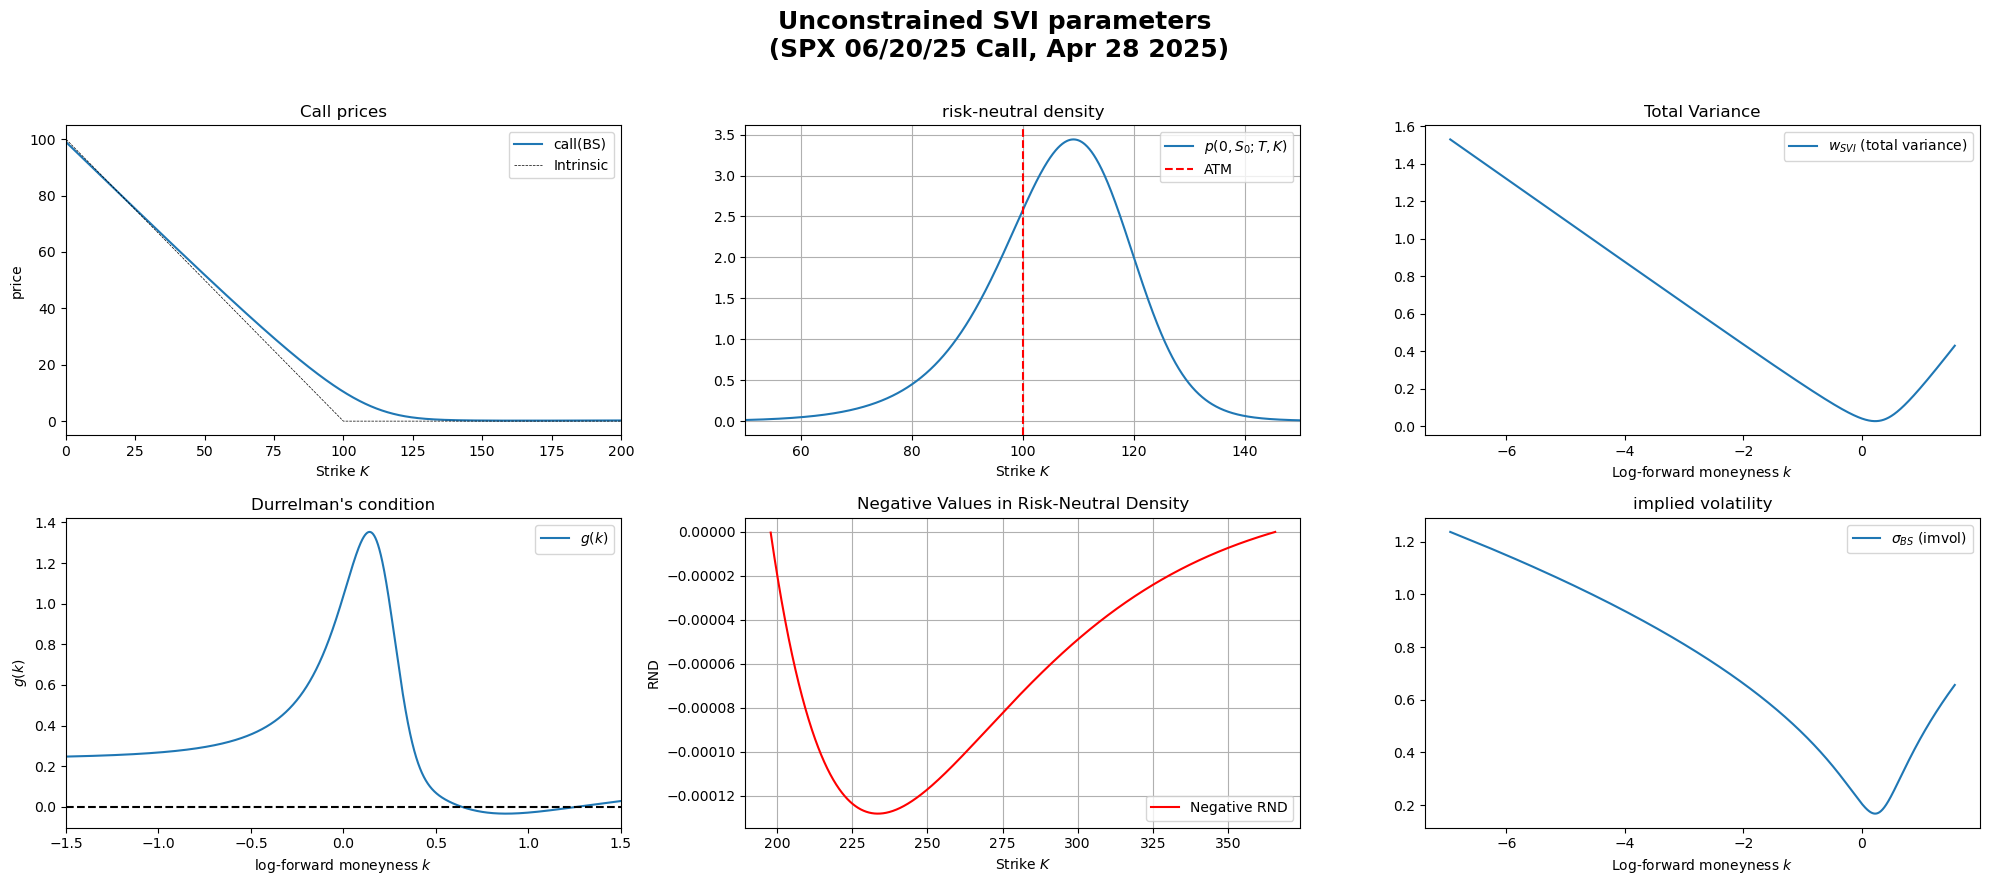

In [228]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
axes[0][0].plot(K_lst, call_lst, label='call(BS)')
axes[0][0].plot(K_lst, intrinsic_lst, linestyle="--", color='black', label='Intrinsic', linewidth=0.5)
axes[0][0].set_title("Call prices")
axes[0][0].set_xlabel(r"Strike $K$")
axes[0][0].set_ylabel("price")
axes[0][0].set_xlim(0, S0 * 2)
axes[0][0].legend(loc='upper right')

axes[0][1].plot(K_lst, rnd_lst, label=r'$p(0,S_0;T,K)$')
axes[0][1].set_title('risk-neutral density')
axes[0][1].axvline(S0, linestyle='--', color='red', label='ATM')
axes[0][1].set_xlim(S0*0.5, S0*1.5)
axes[0][1].set_xlabel(r"Strike $K$")
axes[0][1].legend(loc='upper right')
axes[0][1].grid(True)

axes[0][2].plot(k_lst, w_svi_lst, label=r'$w_{SVI}$ (total variance)')
axes[0][2].set_title("Total Variance")
axes[0][2].set_xlabel(r"Log-forward moneyness $k$")
axes[0][2].legend(loc='upper right')

axes[1][0].plot(k_lst, g_lst, label=r"$g(k)$")
axes[1][0].axhline(0, linestyle="--", color='black')
axes[1][0].set_xlabel(r"log-forward moneyness $k$")
axes[1][0].set_ylabel(r"$g(k)$")
axes[1][0].set_title("Durrelman's condition")
axes[1][0].set_xlim(-1.5, 1.5)
axes[1][0].legend(loc='upper right')

neg_mask = rnd_lst < 0
K_neg = K_lst[neg_mask]
rnd_neg = rnd_lst[neg_mask]
axes[1][1].plot(K_neg, rnd_neg, label="Negative RND", color='red')
axes[1][1].set_xlabel(r"Strike $K$")
axes[1][1].set_ylabel("RND")
axes[1][1].set_title("Negative Values in Risk-Neutral Density")
axes[1][1].grid(True)
axes[1][1].legend()

axes[1][2].plot(k_lst, iv_lst, label=r'$\sigma_{BS}$ (imvol)')
axes[1][2].set_title("implied volatility")
axes[1][2].set_xlabel(r"Log-forward moneyness $k$")
axes[1][2].legend(loc='upper right')

plt.tight_layout()
plt.suptitle("Unconstrained SVI parameters\n (SPX 06/20/25 Call, Apr 28 2025)", fontsize=18, fontweight='bold', y=1.1)
plt.show()